In [1]:
#pip install numpy==1.19, tensorflow==2.3.0

In [2]:
import numpy as  np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils.extmath import randomized_svd
from tensorflow import keras
import urllib
import os

from DeepPDE.Classes.DPDEGenerator  import DPDEGenerator
from DeepPDE.Classes.DPEDEModel  import DPDEModel
from DeepPDE.Classes.HighwayLayer import *
from DeepPDE.tools.others import *


np.random.seed(42)


In [3]:

nr_samples_surface_plot = 21
nr_samples_scatter_plot = 1000
nr_samples_error_calculation = 10000



In [4]:
nr_nodes_per_layer = 90
initial_learning_rate = 0.001
localisation_parameter = 1/10.

n_train = 100
nr_epochs = 601

## Assets d=2

In [5]:
# Model parameters. Re-train model after any changes.
s_min_interest = 25
s_max_interest = 150
t_min_interest = 0.5
t_max_interest = 4.

riskfree_rate_min = 0.1
riskfree_rate_max = 0.3
riskfree_rate_eval = 0.2

volatility_min = 0.1
volatility_max = 0.3
volatility1_eval = 0.1
volatility2_eval = 0.3

correlation_min = 0.2
correlation_max = 0.8
correlation_eval = 0.5

strike_price = 100.

In [6]:
dimension_states =2  
dimension_parameter =4
dimension_totale= 1+ dimension_states +dimension_parameter



In [7]:
normalise =transform(0,t_max=t_max, strike_price=strike,volatility_min= volatility_min,
                     volatility_max= volatility_max,normalise_min=normalised_min,normalise_max=normalised_max,r_min=0.01,
                     r_max= 0.09,rho_min= 0.1,rho_max= 0.9)


t_min_interest_normalised = normalise.normalise_time(t_min_interest)
t_max_interest_normalised = normalise.normalise_time(t_max_interest)

diff_dx = (normalised_max-normalised_min) / (x_max-x_min) 
diff_dt = (normalised_max-normalised_min) / (t_max-t_min)

riskfree_rate_eval_normalised = normalise.normalise_riskfree_rate(riskfree_rate_eval)
volatility1_eval_normalised = normalise.normalise_volatility(volatility1_eval)
volatility2_eval_normalised = normalise.normalise_volatility(volatility2_eval)
correlation_eval_normalised = normalise.normalise_correlation(correlation_eval)

In [8]:
%%time
load_model = False
if load_model:
    # Load model from local folder. If it is not availabe, download it.
    os.makedirs('model/variables', exist_ok=True)
    url_base = 'https://github.com/LWunderlich/DeepPDE/raw/main/TwoAssetsExample/'
    filename = 'model/saved_model.pb'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)
        
    filename = 'model/variables/variables.data-00000-of-00001'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)

    filename = 'model/variables/variables.index'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)

    model = keras.models.load_model('model')   
else:
    # Create and train model from scratch. 
    inputs = keras.Input(shape=(dimension_totale))
    outputs = create_network(inputs,nr_nodes_per_layer,localisation_parameter,dimension_totale)
    model = DPDEModel(inputs=inputs, outputs=outputs) 
    batch_generator = DPDEGenerator(n_train,normalised_min,normalised_max,dimension_states, dimension_parameter)
    model.compile(optimizer=tf.keras.optimizers.Adam(initial_learning_rate))
    callback = tf.keras.callbacks.EarlyStopping('loss', patience=50, restore_best_weights=True)
    model.fit(x=batch_generator, epochs=nr_epochs, steps_per_epoch=10,
                          callbacks=[callback])
   

2023-04-26 23:47:44.231011: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 23:47:44.288781: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc42db9c600 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-04-26 23:47:44.288812: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Epoch 1/601
10/10 [==============================] - 0s 35ms/step - loss: 36360.1616 - loss initial: 30350.0906 - loss interior: 6010.0711
Epoch 2/601
10/10 [==============================] - 0s 42ms/step - loss: 39877.7301 - loss initial: 35983.5890 - loss interior: 3894.1411
Epoch 3/601
10/10 [==============================] - 0s 31ms/step - loss: 34695.7383 - loss initial: 31354.3267 - loss interior: 3341.4119
Epoch 4/601
10/10 [==============================] - 0s 30ms/step - loss: 29860.2573 - loss initial: 22701.0874 - loss interior: 7159.1705
Epoch 5/601
10/10 [==============================] - 1s 55ms/step - loss: 28410.5687 - loss initial: 22885.3336 - loss interior: 5525.2346
Epoch 6/601
10/10 [==============================] - 1s 57ms/step - loss: 23828.4359 - loss initial: 21184.7834 - loss interior: 2643.6526
Epoch 7/601
10/10 [==============================] - 1s 95ms/step - loss: 23433.9260 - loss initial: 17680.9722 - loss interior: 5752.9533
Epoch 8/601
10/10 [========

In [9]:
#from DeepPDE.tools.others

test_solution = exact_solution(t=4., s1=100., s2=100., riskfree_rate=0.2, 
               volatility1=0.1, volatility2=0.3, correlation=0.5)

assert(np.abs(test_solution - 55.096796282039364) < 1e-10)


In [10]:
sigma =np.array([0.01, 0.015, 0.015, 0.09]).reshape((2,2))
s=[100,200]

test = exact_solution2(t=4, s=s, sigma=sigma, riskfree_rate=0.2, dimension_states=2)

In [11]:
s1_plot_mesh, s2_plot_mesh, x_plot_normalised = get_points_for_plot_at_fixed_time(t_max,s_max_interest,s_min_interest,
                                                                                  riskfree_rate_eval,volatility1_eval, volatility2_eval,correlation_eval,
                                                                                  nr_samples_surface_plot)



In [12]:
DPDE_solution = model.predict(x_plot_normalised).reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)

exact_solution_evaluated = [exact_solution(t=t_max, s1=s1[0], s2=s2[0], 
                                riskfree_rate=riskfree_rate_eval, 
                                volatility1=volatility1_eval, 
                                volatility2=volatility2_eval,
                                correlation=correlation_eval)
                  for s1, s2 in zip(
                      s1_plot_mesh.reshape(-1, 1), s2_plot_mesh.reshape(-1, 1))
                  
                  ]
exact_solution_evaluated = np.array(exact_solution_evaluated)
exact_solution_evaluated = exact_solution_evaluated.reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)


localisation_plot = localisation(4., s1_plot_mesh, s2_plot_mesh,localisation_parameter,strike_price, riskfree_rate_eval)

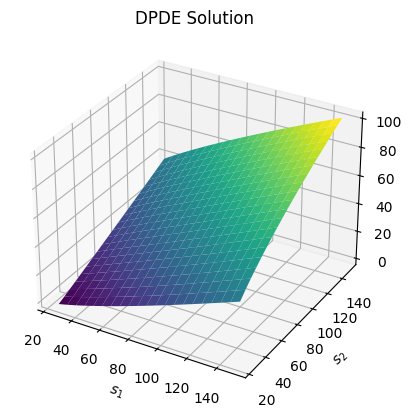

In [13]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, DPDE_solution, cmap='viridis')
ax.set_title('DPDE Solution')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

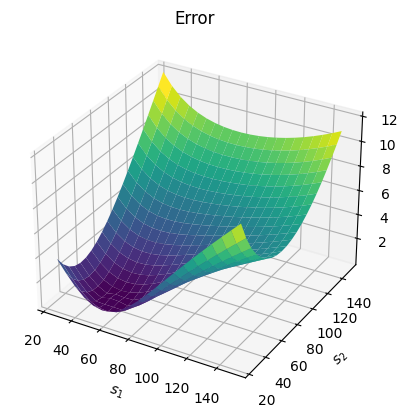

In [14]:
fig = plt.figure()
ax = plt.axes(projection='3d')

error = np.abs(DPDE_solution - exact_solution_evaluated)
ax.plot_surface(s1_plot_mesh, s2_plot_mesh, error, cmap='viridis')
ax.set_title('Error')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

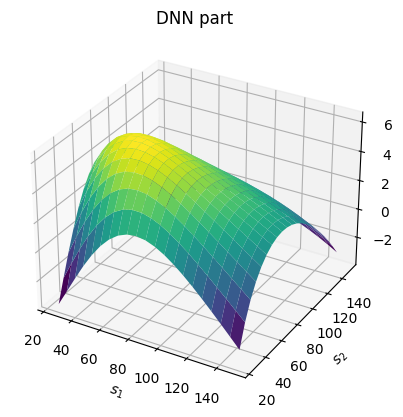

In [15]:
fig = plt.figure()
ax = plt.axes(projection='3d')

dnn_part = DPDE_solution - localisation_plot
ax.plot_surface(s1_plot_mesh, s2_plot_mesh, dnn_part, cmap='viridis')
ax.set_title('DNN part')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

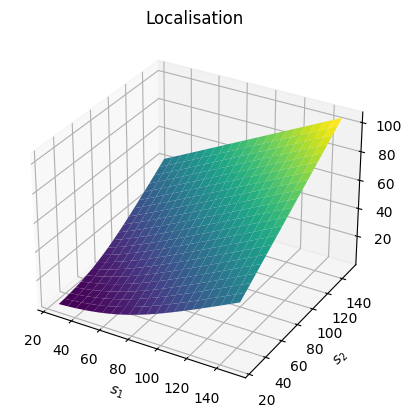

In [16]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, localisation_plot, cmap='viridis')
ax.set_title('Localisation')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

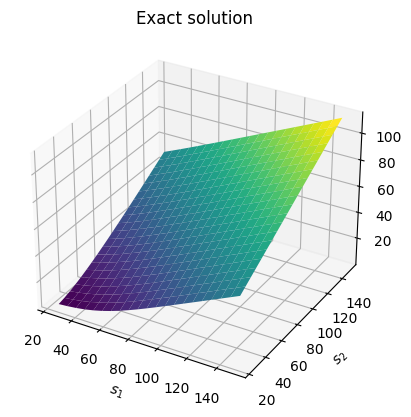

In [17]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, exact_solution_evaluated, cmap='viridis')
ax.set_title('Exact solution')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

### Volatilié implicite

In [19]:
Implied_Volatility_Explicit = [Implied_Volatility_bis(Price=exact_solution(t=t_max, s1=s1[0], s2=s2[0], 
                                riskfree_rate=riskfree_rate_eval, 
                                volatility1=volatility1_eval, 
                                volatility2=volatility2_eval,
                                correlation=correlation_eval),S=0.5*(s1[0]+s2[0]),strike_price=100,riskfree_rate=riskfree_rate_eval,T=4)
                  for s1, s2 in zip(
                      s1_plot_mesh.reshape(-1, 1), s2_plot_mesh.reshape(-1, 1))]

Implied_Volatility_Explicit = np.array(Implied_Volatility_Explicit)
Implied_Volatility_Explicit = Implied_Volatility_Explicit.reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)

In [20]:
Implied_Volatility_DPDE = [Implied_Volatility_bis(Price=
                                              model.predict(np.array([normalise.normalise_time(t_max), normalise.normalise_logprice(np.log(s1[0])),
                                              normalise.normalise_logprice(np.log(s2[0])), normalise.normalise_riskfree_rate(riskfree_rate_eval), 
                                              normalise.normalise_volatility(volatility1_eval), normalise.normalise_volatility(volatility2_eval), 
                                              normalise.normalise_correlation(correlation_eval)]).reshape(1,7))[0][0]
                                              ,S=0.5*(s1[0]+s2[0]),strike_price=100,riskfree_rate=riskfree_rate_eval,T=4)
                  for s1, s2 in zip(
                      s1_plot_mesh.reshape(-1, 1), s2_plot_mesh.reshape(-1, 1))]

Implied_Volatility_DPDE = np.array(Implied_Volatility_DPDE)
Implied_Volatility_DPDE = Implied_Volatility_DPDE.reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)

9.999999935796384e-08 60.948326 61.317103588277845 106.25 100 0.2 4
9.999999935796384e-08 57.442596 58.192103588277845 103.125 100 0.2 4
9.999999935796384e-08 53.922985 55.067103588277845 100.0 100 0.2 4
9.999999935796384e-08 50.363895 51.942103588277845 96.875 100 0.2 4
9.999999935796384e-08 46.744736 48.817103588277845 93.75 100 0.2 4
9.999999935796384e-08 43.066658 45.692103588277845 90.625 100 0.2 4
9.999999935796384e-08 39.381886 42.567103588277845 87.5 100 0.2 4
9.999999935796384e-08 64.10025 64.44210358827785 109.375 100 0.2 4
9.999999935796384e-08 60.580788 61.317103588277845 106.25 100 0.2 4
9.999999935796384e-08 57.08549 58.192103588277845 103.125 100 0.2 4
9.999999935796384e-08 53.59954 55.067103588277845 100.0 100 0.2 4
9.999999935796384e-08 50.103104 51.942103588277845 96.875 100 0.2 4
9.999999935796384e-08 46.57464 48.817103588277845 93.75 100 0.2 4
9.999999935796384e-08 42.999104 45.692103588277845 90.625 100 0.2 4
9.999999935796384e-08 39.384644 42.567103588277845 87.5 

### Erreur entre vol implicit exact price et PDE price 

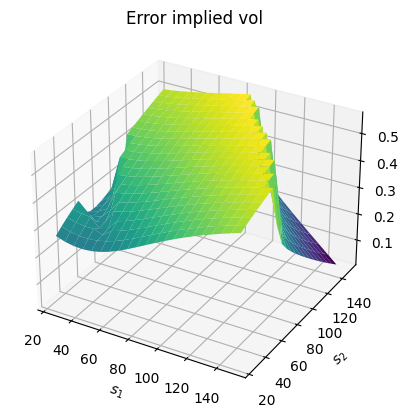

In [21]:
fig = plt.figure()
ax = plt.axes(projection='3d')

error = np.abs(Implied_Volatility_DPDE - Implied_Volatility_Explicit)
ax.plot_surface(s1_plot_mesh, s2_plot_mesh, error, cmap='viridis')
ax.set_title('Error implied vol')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

## Assets d=3

In [ ]:
dim_states =3  
dim_parameter =4 #equal correlation
dim_totale= 1+ dim_states +dim_parameter




In [ ]:
sigm_eval = np.random.uniform(0.08, 0.3, dim_states**2).reshape((dim_states,dim_states))
correlation_eval = np.array([1., 0.3, 0.3, 0.3, 1., 0.3, 0.3, 0.3, 1. ]).reshape((dim_states, dim_states))


In [ ]:
normalise =transform(0,t_max=t_max, strike_price=strike,volatility_min= volatility_min,
                     volatility_max= volatility_max,normalise_min=normalised_min,normalise_max=normalised_max,r_min=0.01,
                     r_max= 0.09,rho_min= 0.1,rho_max= 0.9)


diff_dx = (normalised_max-normalised_min) / (x_max-x_min) 
diff_dt = (normalised_max-normalised_min) / (t_max-t_min)

sigma_eval_normalised=normalise.normalise_sigma(sigm_eval, dim_states)
correlation_eval_normalised = normalise.normalise_correlation(correlation_eval)

riskfree_rate_eval_normalised = normalise.normalise_riskfree_rate(riskfree_rate_eval)
